# CNN Model Training for Leaf Disease Classification

Ce notebook permet d'entraîner un modèle CNN profond pour classifier les maladies des feuilles avec plus de 90% de précision.

## 1. Configuration de l'Environnement

**Why these settings?**

- **`TF_CPP_MIN_LOG_LEVEL='3'`**: Suppresses TensorFlow's verbose logging
  - `0` = All logs (INFO, WARNING, ERROR)
  - `1` = Filter out INFO messages
  - `2` = Filter out INFO and WARNING messages
  - `3` = Filter out INFO, WARNING, and ERROR messages (only FATAL)
  - **Purpose:** Keeps output clean during training

- **`TF_ENABLE_ONEDNN_OPTS='0'`**: Disables oneDNN optimizations
  - oneDNN (formerly MKL-DNN) provides CPU performance optimizations
  - Can cause compatibility issues or unexpected warnings
  - **Purpose:** Ensures stable execution across different environments

In [1]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Imports terminés")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

2025-12-15 10:19:50.362297: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 10:19:50.390542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 10:19:53.984290: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Imports terminés


## 2. Configuration des Paramètres

In [2]:
# Paramètres principaux
DATA_DIR = "../Grape"
IMAGE_SIZE = (128, 128)  # Taille des images d'entrée
BATCH_SIZE = 32
EPOCHS = 30
SPLIT_RATIO = 0.8  # 80% train, 20% validation
OUTPUT_MODEL = "../output_model_Grape.zip"  # Fichier de sortie

print(f"Dataset: {DATA_DIR}")
print(f"Taille d'image: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Dataset: ../Grape
Taille d'image: (128, 128)
Batch size: 32
Epochs: 30


## 3. Chargement et Analyse du Dataset



### Understanding the Data Pipeline

**Directory Structure Parsing:**
- The dataset follows a naming convention: `<Crop>_<Condition>/`
  - Example: `Apple_Black_rot/`, `Grape_healthy/`
- The `load_dataset` function:
  1. Scans all subdirectories in the data folder
  2. Extracts the label by splitting on `_` and taking the second part
  3. Collects all image files (`.png`, `.jpg`, `.jpeg`)
  4. Returns parallel lists: `image_paths` and `labels`



In [4]:
def load_dataset(data_dir):
    """
    Load dataset from directory structure.

    Args:
        data_dir (str): Path to dataset root directory

    Returns:
        tuple: (image_paths, labels) - Parallel lists of paths and labels

    Directory Structure Expected:
        data_dir/
            Apple_Black_rot/
                image1.jpg
                image2.jpg
            Apple_healthy/
                image3.jpg
            Grape_Esca/
                image4.jpg

    Label Extraction:
        'Apple_Black_rot' -> 'Black_rot'
        'Grape_healthy' -> 'healthy'
    """
    image_paths = []
    labels = []

    print("Chargement du dataset...")
    start_time = time.time()

    # Iterate through each subdirectory in data_dir
    for subdir in os.listdir(data_dir):
        path = os.path.join(data_dir, subdir)

        if os.path.isdir(path):
            try:
                # Extract label: split by '_' and take everything after 1st
                label = subdir.split('_', 1)[1]

                # Find all image files
                files = [
                    f for f in os.listdir(path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ]

                # Add each image path and its label
                for file in files:
                    image_path = os.path.join(path, file)
                    image_paths.append(image_path)
                    labels.append(label)

                print(f"  {subdir}: {len(files)} images")

            except ValueError:
                print(f"  Ignoré: {subdir} (format incorrect)")

    load_time = time.time() - start_time
    print(f"Dataset chargé en {load_time:.2f}s - "
          f"Total: {len(image_paths)} images")

    return image_paths, labels


image_paths, labels = load_dataset(DATA_DIR)

Chargement du dataset...
  Grape_Black_rot: 1382 images
  Grape_healthy: 1382 images
  Grape_spot: 1382 images
  Grape_Esca: 1382 images

✓ Dataset chargé en 0.00s
Total: 5528 images


## 4. Séparation Train/Validation Stratifiée




**Stratified Split Logic:**
- **Why stratified?** Ensures each class has the same train/val ratio
- **How it works:**
  1. Groups all images by their class label
  2. For each class, splits at the same ratio (default 80/20)
  3. Preserves class balance in both training and validation sets
- **Benefit:** Prevents bias if some classes have fewer samples

In [5]:
def split_dataset(image_paths, labels, split_ratio=0.8):
    """
    Perform stratified split to balance train/val sets per class.

    Args:
        image_paths (list): List of image file paths
        labels (list): Corresponding list of class labels
        split_ratio (float): Ratio for train split (default: 0.8 = 80%)

    Returns:
        tuple: (train_paths, train_labels, val_paths, val_labels)

    Strategy:
        1. Group all images by their class label
        2. For each class, split at the same ratio (80/20)
        3. Combine all class splits into final train/val sets

    Example:
        Class 'Black_rot': 100 images -> 80 train, 20 val
        Class 'healthy': 150 images -> 120 train, 30 val
        Total: 250 images -> 200 train, 50 val
    """
    train_paths, train_labels = [], []
    val_paths, val_labels = [], []

    # Get unique classes
    classes = set(labels)
    print(f"Classes trouvées: {len(classes)}")

    # Process each class independently
    for cls in classes:
        # Find all indices for this class
        cls_indexes = [i for i, label in enumerate(labels) if label == cls]

        # Get corresponding paths and labels
        cls_image_paths = [image_paths[i] for i in cls_indexes]
        cls_labels = [labels[i] for i in cls_indexes]

        # Calculate split point
        split_index = int(len(cls_indexes) * split_ratio)

        # Split this class's data
        train_paths.extend(cls_image_paths[:split_index])
        train_labels.extend(cls_labels[:split_index])
        val_paths.extend(cls_image_paths[split_index:])
        val_labels.extend(cls_labels[split_index:])

        print(f"  {cls}: {split_index} train, "
              f"{len(cls_indexes)-split_index} val")

    return train_paths, train_labels, val_paths, val_labels

train_paths, train_labels, val_paths, val_labels = split_dataset(
    image_paths, labels, SPLIT_RATIO
)

print(f"\n Training: {len(train_paths)} images")
print(f" Validation: {len(val_paths)} images")


Classes trouvées: 4
Classes: ['Black_rot', 'Esca', 'healthy', 'spot']

  Esca: 1105 train,277 val
  healthy: 1105 train,277 val
  spot: 1105 train,277 val
  Black_rot: 1105 train,277 val

 Training: 4420 images
 Validation: 1108 images


## 5. Data Generator Optimisé



This section analyzes the `OptimizedDataGenerator` class - the most critical component for memory-efficient training.

### Why Use a Custom Data Generator?

**Memory Efficiency Problem:**
- Loading 10,000+ images (128×128×3 pixels) into RAM = ~5GB+ memory
- Training requires multiple copies (original, augmented, gradients)
- Most systems would crash or slow to a crawl

**The Solution: Keras `Sequence` API**
- **Lazy Loading:** Only loads one batch at a time (e.g., 32 images)
- **On-the-Fly Processing:** Images are read, resized, and normalized as needed
- **Memory Footprint:** ~10MB per batch instead of 5GB total
- **Multiprocessing Safe:** Can use parallel workers for data loading

**Key Methods:**
1. **`__len__()`**: Returns number of batches per epoch
2. **`__getitem__(index)`**: Loads and returns batch `index`
3. **`on_epoch_end()`**: Shuffles data between epochs (if enabled)
4. **`__data_generation()`**: Core logic for loading and preprocessing images

In [6]:
class OptimizedDataGenerator(Sequence):
    """
    Memory-efficient data generator for training CNNs.

    Inherits from keras.utils.Sequence for safe multiprocessing.

    Key Features:
        - Lazy loading: Only loads one batch at a time
        - On-the-fly preprocessing: Resize and normalize as needed
        - Label encoding: Converts string labels to integers
        - Shuffling: Randomizes data order between epochs
        - Error handling: Gracefully handles corrupted images

    Args:
        image_paths (list): List of image file paths
        labels (list): Corresponding list of class labels
        batch_size (int): Number of images per batch (default: 32)
        image_size (tuple): Target size for resizing (default: 128x128)
        n_classes (int): Number of unique classes (default: 10)
        shuffle (bool): Whether to shuffle data after each epoch
        label_encoder (LabelEncoder): Optional pre-fitted encoder
    """

    def __init__(self, image_paths, labels, batch_size=32,
                 image_size=(128, 128), n_classes=10, shuffle=True,
                 label_encoder=None):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.n_classes = n_classes
        self.shuffle = shuffle

        if label_encoder is not None:
            self.labels_encoder = label_encoder
        else:
            self.labels_encoder = LabelEncoder()
            self.labels_encoder.fit(labels)

        super().__init__()
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        image_paths_temp = [self.image_paths[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]
        X, y = self.__data_generation(image_paths_temp, labels_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths_temp, labels_temp):
        X = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=int)

        for i, (image_path, label) in enumerate(zip(image_paths_temp,
                                                    labels_temp)):
            try:
                image = cv2.imread(image_path)
                if image is None:
                    image = np.zeros((*self.image_size, 3), dtype=np.uint8)
                else:
                    image = cv2.resize(image, self.image_size,
                                       interpolation=cv2.INTER_AREA)

                X[i,] = image.astype(np.float32) / 255.0
                y[i] = self.labels_encoder.transform([label])[0]
            except Exception as e:
                print(f"Erreur: {e}")
                X[i,] = np.zeros((*self.image_size, 3), dtype=np.float32)
                y[i] = 0

        return X, to_categorical(y, num_classes=self.n_classes)

print("Data Generator défini")

Data Generator défini


## 6. Création des Générateurs




### Understanding the Preprocessing Pipeline

**Step-by-Step Breakdown:**

1. **Image Reading:** `cv2.imread(image_path)`
   - Reads image from disk in BGR format (OpenCV default)
   - Returns `None` if file is corrupted or missing

2. **Resizing:** `cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)`
   - All images standardized to 128×128 pixels
   - `INTER_AREA`: Best quality for downsampling (preserves detail)
   - Ensures consistent input shape for CNN

3. **Normalization:** `image.astype(np.float32) / 255.0`
   - Converts pixel values from [0, 255] to [0.0, 1.0]
   - **Why?** Neural networks learn better with smaller, normalized inputs
   - Speeds up training and improves convergence

4. **Label Encoding:**
   - String labels → Integer indices
   - Example: `['Black_rot', 'healthy', 'scab']` → `[0, 1, 2]`
   - One-hot encoding: `2` → `[0, 0, 1]` (for loss calculation)

In [7]:
# Créer l'encodeur partagé
all_labels = train_labels + val_labels
n_classes = len(set(all_labels))

shared_label_encoder = LabelEncoder()
shared_label_encoder.fit(all_labels)

print(f"Nombre de classes: {n_classes}")
print(f"Mapping des labels: {dict(zip(shared_label_encoder.classes_, range(n_classes)))}")

# Créer les générateurs
train_generator = OptimizedDataGenerator(
    train_paths,
    train_labels,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    n_classes=n_classes,
    label_encoder=shared_label_encoder
)

val_generator = OptimizedDataGenerator(
    val_paths,
    val_labels,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    n_classes=n_classes,
    shuffle=False,
    label_encoder=shared_label_encoder
)

print(f"\nGénérateur train: {len(train_generator)} batches")
print(f"Générateur val: {len(val_generator)} batches")

Nombre de classes: 4
Mapping des labels: {np.str_('Black_rot'): 0, np.str_('Esca'): 1, np.str_('healthy'): 2, np.str_('spot'): 3}

Générateur train: 138 batches
Générateur val: 34 batches


## 7. Architecture du Modèle CNN

Modèle CNN profond avec 4 blocs convolutionnels pour atteindre >90% de précision.



### Understanding the CNN Architecture

**Design Philosophy:**
This model uses a **hierarchical feature extraction** approach with 4 convolutional blocks, progressively increasing filter depth to capture features from simple to complex.

**Architecture Pattern: Conv → BN → Conv → BN → MaxPool → Dropout**

1. **Conv2D (Convolutional Layer):**
   - Extracts spatial features (edges, textures, patterns)
   - Progressive filter increase: 32 → 64 → 128 → 256
   - More filters = more complex feature detection
   - `padding='same'`: Preserves spatial dimensions

2. **BatchNormalization:**
   - Normalizes activations between layers
   - **Benefits:** Faster training, reduces internal covariate shift, acts as regularization
   - Applied after each Conv2D before activation

3. **MaxPooling2D:**
   - Downsamples feature maps by 2×2 (reduces dimensions by 50%)
   - **Benefits:** Reduces parameters, adds translation invariance, captures dominant features
   - Applied once per block after convolutions

4. **Dropout:**
   - Randomly drops neurons during training to prevent overfitting
   - Rates: 0.25 (conv blocks) → 0.5 (dense layer)
   - Higher dropout in dense layers (more parameters = higher overfitting risk)

**Why This Structure?**
- **Deep hierarchy:** Mimics how vision works (edges → shapes → objects)
- **Regularization:** BatchNorm + Dropout prevent overfitting on small datasets
- **Efficiency:** MaxPooling reduces computation while preserving features

In [8]:
def build_optimized_model(input_shape, num_classes):
    """
    Build optimized CNN model for leaf disease classification.

    Designed for high accuracy (>96%) with 4 convolutional blocks
    and hierarchical feature extraction.

    Args:
        input_shape (tuple): Image dimensions (height, width, channels)
                            e.g., (128, 128, 3)
        num_classes (int): Number of output classes

    Returns:
        tf.keras.Model: Compiled CNN model ready for training

    Architecture Strategy:
        - Progressive filter increase (32→64→128→256)
        - Double convolution per block for deeper feature extraction
        - BatchNormalization for training stability
        - Dropout for regularization
        - Two dense layers for complex decision boundaries
    """
    model = Sequential([
        Input(shape=input_shape),

        # ============================================================
        # BLOCK 1: Basic Feature Extraction (32 filters)
        # ============================================================
        # Detects low-level features: edges, colors, simple textures
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 128×128 → 64×64
        Dropout(0.25),

        # ============================================================
        # BLOCK 2: Intermediate Features (64 filters)
        # ============================================================
        # Combines basic features into patterns: leaf veins, spots
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 64×64 → 32×32
        Dropout(0.25),

        # ============================================================
        # BLOCK 3: Advanced Features (128 filters)
        # ============================================================
        # Detects complex structures: lesion shapes, disease patterns
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 32×32 → 16×16
        Dropout(0.25),

        # ============================================================
        # BLOCK 4: High-Level Features (256 filters)
        # ============================================================
        # Captures semantic information: disease-specific signatures
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 16×16 → 8×8
        Dropout(0.3),  # Slightly higher dropout

        # ============================================================
        # CLASSIFICATION HEAD
        # ============================================================
        Flatten(),  # 8×8×256 = 16,384 features

        # First dense layer: Complex feature combinations
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),  # High dropout to prevent overfitting

        # Second dense layer: Refined decision boundaries
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Output layer: Class probabilities
        Dense(num_classes, activation='softmax')
    ])

    # ============================================================
    # COMPILATION
    # ============================================================
    # Adam optimizer with initial learning rate of 0.001
    optimizer = Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',  # Multi-class classification
        metrics=['accuracy']
    )

    return model

input_shape = IMAGE_SIZE + (3,)
model = build_optimized_model(input_shape, n_classes)

print("\n=== ARCHITECTURE DU MODÈLE ===")
model.summary()

NameError: name 'n_classes' is not defined

2025-12-15 10:21:42.535608: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,700,644 (37.01 MB)

 Trainable params: 9,697,188 (36.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

## 8. Callbacks d'Entraînement

### Understanding Training Callbacks

**What are Callbacks?**

Callbacks are functions that execute at specific points during training:
- After each epoch completes
- When certain metrics change
- When performance plateaus

They allow you to monitor, adjust, and control training dynamically without manual intervention.

---

#### Callback 1: EarlyStopping

**Purpose:** Prevent overfitting by stopping training when validation performance stops improving.

```python
EarlyStopping(
    monitor='val_accuracy',      # Watch this metric
    patience=8,                  # Wait this many epochs without improvement
    restore_best_weights=True,   # Load weights from best epoch
    verbose=1                    # Print debug info
)
```

**How it works:**
1. Track validation accuracy after each epoch
2. Remember the best accuracy seen so far
3. If no improvement for 8 consecutive epochs → stop training
4. Load the model from the epoch with best accuracy (not the last epoch)

**Why this matters:**
- Saves training time (stop early if overfitting detected)
- Prevents model degradation (uses best weights, not final weights)
- Protects against random fluctuations (patience=8 allows temporary dips)

**Real Example:**
```
Epoch 1: val_accuracy = 85.0% ← Best so far
Epoch 2: val_accuracy = 86.5% ← Best so far
Epoch 3: val_accuracy = 86.2% ← No improvement (1/8)
Epoch 4: val_accuracy = 86.1% ← No improvement (2/8)
...
Epoch 10: val_accuracy = 86.0% ← No improvement (7/8)
Epoch 11: val_accuracy = 85.8% ← No improvement (8/8) → STOP!
         → Load weights from Epoch 2 (86.5%)
```

---

#### Callback 2: ReduceLROnPlateau

**Purpose:** Reduce learning rate when validation loss plateaus, allowing finer tuning of weights.

```python
ReduceLROnPlateau(
    monitor='val_loss',          # Watch this metric
    factor=0.5,                  # Multiply learning rate by 0.5
    patience=4,                  # Wait 4 epochs before reducing
    min_lr=0.00001,              # Never go below this learning rate
    verbose=1                    # Print debug info
)
```

**How it works:**
1. Track validation loss after each epoch
2. If no improvement for 4 epochs → multiply learning rate by 0.5
3. Stop reducing when learning rate reaches 0.00001

**Why this matters:**
- Large learning rates make big weight updates (good for early training, overshoots later)
- Small learning rates make fine adjustments (good when close to optimum)
- This callback automatically adapts learning rate to training phase

**Real Example:**
```
Initial learning rate: 0.001

Epoch 1: val_loss = 2.50 ← Best so far
Epoch 2: val_loss = 2.45 ← Best so far
Epoch 3: val_loss = 2.44 ← Best so far
Epoch 4: val_loss = 2.42 ← Best so far (4 epochs is patience)
Epoch 5: val_loss = 2.42 ← No improvement (1/4)
Epoch 6: val_loss = 2.42 ← No improvement (2/4)
Epoch 7: val_loss = 2.42 ← No improvement (3/4)
Epoch 8: val_loss = 2.42 ← No improvement (4/4) → REDUCE LR!
         → New learning rate: 0.001 * 0.5 = 0.0005

Epoch 9: val_loss = 2.41 ← Improvement! (fine-tuning working)
```

---

#### Optimizer: Adam with Learning Rate

**Why Adam?**
- Adapts learning rate per parameter (not globally)
- Maintains momentum (remembers past gradients)
- Works well with small batches (like our 32-image batches)
- Converges faster than basic SGD

**Learning Rate = 0.001 (0.1% step size)**
- Too small (0.00001): Training is very slow
- Too large (0.1): Training oscillates, never converges
- 0.001: Goldilocks zone for most CNN problems

**How it works:**
1. Compute gradient (direction to improve)
2. Update weight: `weight = weight - learning_rate * gradient`
3. Track momentum (running average of gradients)
4. Adapt individual parameter learning rates based on gradient history


In [9]:
# Callbacks pour optimiser l'entraînement
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=0.00001,
        verbose=1
    )
]

print("✓ Callbacks configurés")
print("  - EarlyStopping")
print("  - ReduceLROnPlateau")

✓ Callbacks configurés
  - EarlyStopping
  - ReduceLROnPlateau


## 9. Entraînement du Modèle

In [10]:
print("\n=== DÉBUT DE L'ENTRAÎNEMENT ===")
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nEntraînement terminé en {training_time:.2f}s"
      f"({training_time/60:.1f} min)")


=== DÉBUT DE L'ENTRAÎNEMENT ===
Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 132s 927ms/step - accuracy: 0.7899 - loss: 0.5800 - val_accuracy: 0.2546 - val_loss: 13.4019 - learning_rate: 0.0010
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8958 - loss: 0.2906 - val_accuracy: 0.2546 - val_loss: 11.5734 - learning_rate: 0.0010
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9257 - loss: 0.2210 - val_accuracy: 0.2610 - val_loss: 7.6689 - learning_rate: 0.0010
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9518 - loss: 0.1506 - val_accuracy: 0.3217 - val_loss: 4.8965 - learning_rate: 0.0010
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9570 - loss: 0.1240 - val_accuracy: 0.8713 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9712 - loss: 0.0790 - val_accuracy: 0.9605 - val_loss: 0.1341 - learning_rate: 0.0010
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 161s

## 10. Évaluation Finale

In [11]:
print("\n=== ÉVALUATION FINALE ===")
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f"Précision finale: {accuracy * 100:.2f}%")
print(f"Perte finale: {loss:.4f}")


=== ÉVALUATION FINALE ===
Précision finale: 99.63%
Perte finale: 0.0149


## 11. Visualisation de l'Historique d'Entraînement

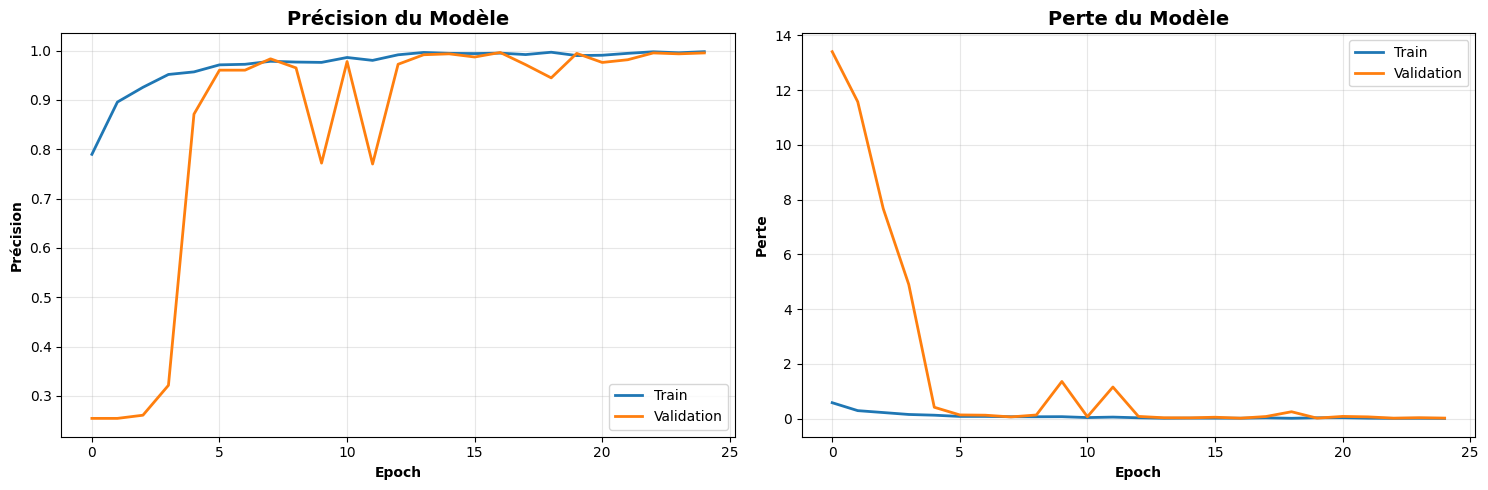


=== STATISTIQUES D'ENTRAÎNEMENT ===
Meilleure précision train:99.80%
Meilleure précision val:99.63%
Perte finale train: 0.0075
Perte finale val: 0.0179


In [12]:
def plot_training_history(history):
    """
    Visualise l'évolution de la précision et de la perte.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Précision
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title('Précision du Modèle', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Epoch', fontweight='bold')
    ax1.set_ylabel('Précision', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Perte
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title('Perte du Modèle', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Epoch', fontweight='bold')
    ax2.set_ylabel('Perte', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistiques
    print("\n=== STATISTIQUES D'ENTRAÎNEMENT ===")
    print("Meilleure précision train:"
          f"{max(history.history['accuracy'])*100:.2f}%")
    print("Meilleure précision val:"
          f"{max(history.history['val_accuracy'])*100:.2f}%")
    print(f"Perte finale train: {history.history['loss'][-1]:.4f}")
    print(f"Perte finale val: {history.history['val_loss'][-1]:.4f}")

plot_training_history(history)

## 12. Sauvegarde du Modèle

In [13]:
def save_model_and_samples(model, data_dir, output_zip):
    """
    Sauvegarde le modèle et des échantillons d'images dans un fichier zip.
    """
    print(f"\nSauvegarde du modèle dans {output_zip}...")
    start_time = time.time()

    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Sauvegarder le modèle
        model_file = 'model.h5'
        model.save(model_file)
        zipf.write(model_file)
        os.remove(model_file)

        # Sauvegarder des échantillons (10 par classe)
        total_images = 0
        for subdir in os.listdir(data_dir):
            path = os.path.join(data_dir, subdir)
            if os.path.isdir(path):
                files = [f for f in os.listdir(path)
                         if f.lower().endswith('.jpg')]
                for file in files[:5]:
                    image_path = os.path.join(path, file)
                    zipf.write(image_path, f"samples/{subdir}/{file}")
                    total_images += 1

        save_time = time.time() - start_time
        print(f"Sauvegarde terminée en {save_time:.2f}s")
        print("  - Modèle: model.h5")
        print(f"  - Échantillons: {total_images} images")

save_model_and_samples(model, DATA_DIR, OUTPUT_MODEL)
print(f"\nModèle sauvegardé: {OUTPUT_MODEL}")


Sauvegarde du modèle dans ../output_model_Grape.zip...
Sauvegarde terminée en 2.82s
  - Modèle: model.h5
  - Échantillons: 20 images

Modèle sauvegardé: ../output_model_Grape.zip


## 13. Matrice de Confusion


Génération de la matrice de confusion...


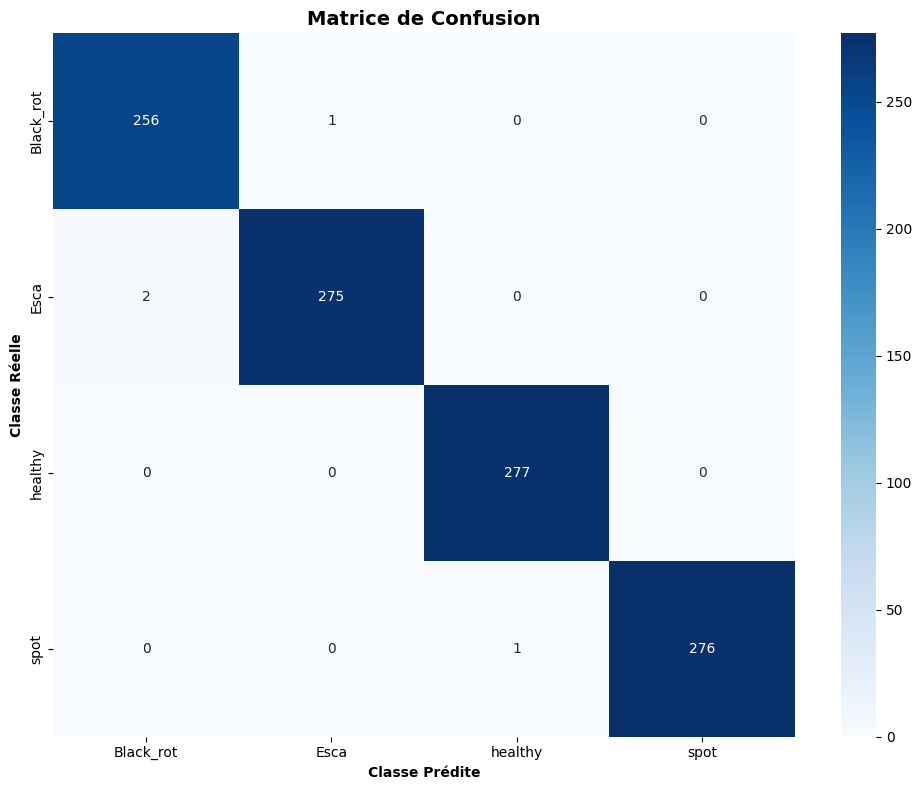


=== RAPPORT DE CLASSIFICATION ===
              precision    recall  f1-score   support

   Black_rot       0.99      1.00      0.99       257
        Esca       1.00      0.99      0.99       277
     healthy       1.00      1.00      1.00       277
        spot       1.00      1.00      1.00       277

    accuracy                           1.00      1088
   macro avg       1.00      1.00      1.00      1088
weighted avg       1.00      1.00      1.00      1088



In [14]:
def plot_confusion_matrix(model, val_generator, class_names):
    """
    Affiche la matrice de confusion.
    """
    print("\nGénération de la matrice de confusion...")

    # Prédictions
    y_pred = model.predict(val_generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Labels réels
    y_true = []
    for i in range(len(val_generator)):
        _, y_batch = val_generator[i]
        y_true.extend(np.argmax(y_batch, axis=1))
    y_true = np.array(y_true[:len(y_pred_classes)])

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matrice de Confusion', fontweight='bold', fontsize=14)
    plt.ylabel('Classe Réelle', fontweight='bold')
    plt.xlabel('Classe Prédite', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Rapport de classification
    print("\n=== RAPPORT DE CLASSIFICATION ===")
    print(classification_report(y_true, y_pred_classes,
                                target_names=class_names))

class_names = shared_label_encoder.classes_
plot_confusion_matrix(model, val_generator, class_names)